In [1]:
import functools
import tensorflow as tf
from core.model import ModelMNIST10x10_base
from core.hessian import diagonal_inverse_hessians_highrank

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(0.1, 0.9, use_nesterov=True)):
        super(Implement, self).__init__(batch_size, opt)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        hessis = diagonal_inverse_hessians_highrank(
                 cost, var_refs, gradients=grads,
                 aggregation_method=None, colocate_gradients_with_ops=True)
        
        second_order_grads = []
        for l, g, h in zip(range(len(grads)), grads, hessis):
            shape = g.shape
            d = int(functools.reduce(lambda a,b: a*b, shape))

            h_inv = tf.reshape(h, shape)
            delta = tf.multiply(h_inv, g)
            second_order_grads.append(delta)
            
            tf.summary.histogram('update/gradient/{}'.format(l), g)
            tf.summary.histogram('update/hessian/{}'.format(l), h)
            tf.summary.histogram('update/delta/{}'.format(l), delta)            
        return second_order_grads

In [2]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

from core.utils import loop
model = Implement(batch_size=50000)
history = loop(model, 30, './summary/8_3_incomplete_second_order_optimization_batch_50000')

[1124 14:29:21 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1124 14:29:21 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[INFO] session initialized
[INFO] [0000] [train] cost:0.680 accuracy:0.072 elapsed:2.291sec [valid] cost:0.524 accuracy:0.075 elapsed:0.042sec
[INFO] [0001] [train] cost:0.524 accuracy:0.085 elapsed:0.190sec [valid] cost:0.347 accuracy:0.087 elapsed:0.006sec
[INFO] [0002] [train] cost:0.345 accuracy:0.093 elapsed:0.190sec [valid] cost:0.429 accuracy:0.098 elapsed:0.006sec
[INFO] [0003] [train] cost:0.422 accuracy:0.096 elapsed:0.190sec [valid] cost:0.356 accuracy:0.089 elapsed:0.006sec
[INFO] [0004] [train] cost:0.358 accuracy:0.095 elapsed:0.200sec [valid] cost:0.336 accuracy:0.097 elapsed:0.006sec
[INFO] [0005] [train] cost:0.337 accuracy:0.096 elapsed:0.190sec [valid] cost:0.333 accuracy:0.097 elapsed:0.006sec
[INFO] [0006] [train] cost:0.333 accura

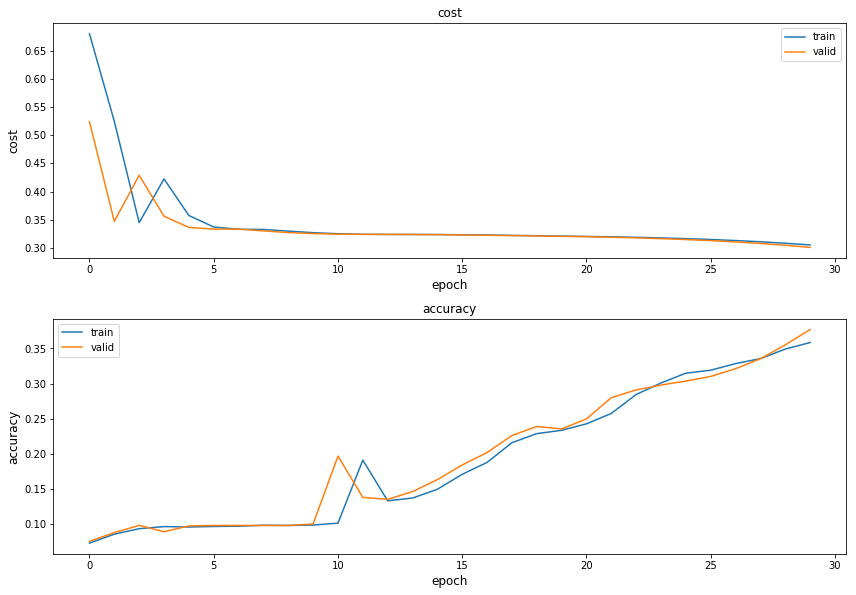

In [3]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)